In [1]:
# Data Wrangling
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline

# EDA
import klib

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Modeling
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVC
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.base import ClassifierMixin
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


# Evaluation
from sklearn.model_selection import cross_val_score

# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean
from sklearn.feature_selection import RFE

import gc
import random
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
with open('../input/data_0614.pkl', 'rb') as f:  # cv.pkl이라는 파일을 바이너리 읽기(rb)모드로 열어서 f라 하고
    data = pickle.load(f)

In [3]:
with open('../input/data_te_0614.pkl', 'rb') as f:  # cv.pkl이라는 파일을 바이너리 읽기(rb)모드로 열어서 f라 하고
    data_te = pickle.load(f)

In [5]:
y_train = pd.read_csv('../input/y_train.csv').age

In [5]:
data.shape, data_te.shape, y_train.shape

((21587, 10819), (14380, 10819), (21587,))

In [6]:
numeric_columns = data.dtypes[data.dtypes != 'object'].index.tolist()

In [7]:
# standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
data_te[numeric_columns] = scaler.transform(data_te[numeric_columns])

In [8]:
# log 변환
#data[numeric_columns] = np.log1p(data[numeric_columns])
#data_te[numeric_columns] = np.log1p(data_te[numeric_columns])

In [8]:
with open('../input/ft_0614.pkl', 'rb') as f:  # cv.pkl이라는 파일을 바이너리 읽기(rb)모드로 열어서 f라 하고
    ft = pickle.load(f)

In [9]:
with open('../input/ft_te_0614.pkl', 'rb') as f:  # cv.pkl이라는 파일을 바이너리 읽기(rb)모드로 열어서 f라 하고
    ft_te = pickle.load(f)

In [10]:
data = pd.concat([data, ft], axis=1)
data_te = pd.concat([data_te, ft_te], axis=1) 

In [11]:
data.shape, data_te.shape, y_train.shape

((21587, 11219), (14380, 11219), (21587,))

### Modeling

In [16]:
data2 = data.values
data_te2 = data_te.values

In [18]:
ftr = data.drop('custid', axis=1)
target = y_train
target_log = np.log1p(target)

In [19]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(ftr, target, test_size=0.3, random_state=0)
train_x.shape, valid_x.shape

((15110, 1247), (6477, 1247))

In [20]:
from lightgbm import LGBMRegressor

clf = LGBMRegressor(
        n_jobs=-1,
        n_estimators=1000,
        learning_rate=0.02,
        num_leaves=32,
        subsample=0.8,
        max_depth=12,
        silent=-1,
        verbose=-1
        )

clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric = 'RMSE', 
        verbose=100, early_stopping_rounds= 50)

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7.68374	training's l2: 59.0399	valid_1's rmse: 8.29925	valid_1's l2: 68.8775
[200]	training's rmse: 6.90881	training's l2: 47.7316	valid_1's rmse: 8.10298	valid_1's l2: 65.6582
[300]	training's rmse: 6.36398	training's l2: 40.5003	valid_1's rmse: 8.05951	valid_1's l2: 64.9556
[400]	training's rmse: 5.92057	training's l2: 35.0532	valid_1's rmse: 8.05057	valid_1's l2: 64.8116
Early stopping, best iteration is:
[372]	training's rmse: 6.03745	training's l2: 36.4508	valid_1's rmse: 8.04698	valid_1's l2: 64.7539


LGBMRegressor(learning_rate=0.02, max_depth=12, n_estimators=1000,
              num_leaves=32, silent=-1, subsample=0.8, verbose=-1)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

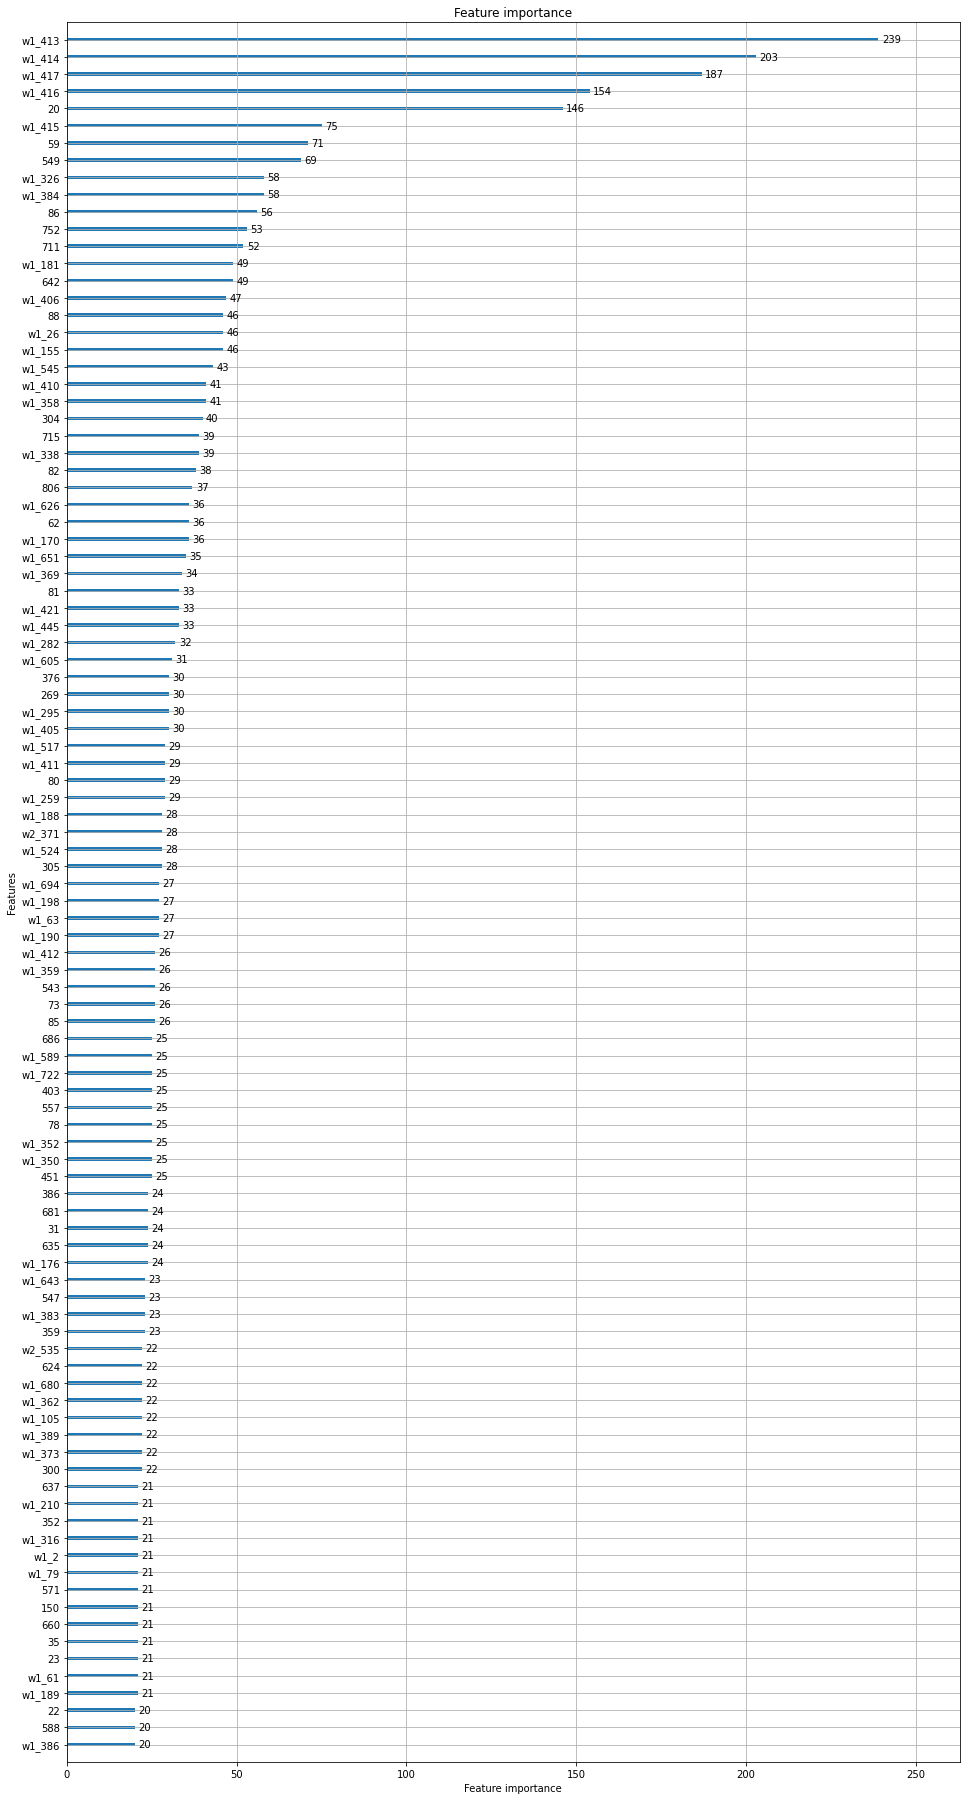

In [21]:
from lightgbm import plot_importance

plot_importance(clf, figsize=(16, 32), max_num_features=100)

#### Feature Selection & Cross Validation

In [38]:
ftr = data2[:, 1:]
target = y_train
target_log = np.log1p(target)

In [39]:
from sklearn.feature_selection import SelectFromModel
smf = SelectFromModel(clf, threshold='5.0*mean')
smf.fit(ftr, target)
X_new = smf.transform(ftr)
X_te_new = smf.transform(data_te2[:, 1:])
feature_idx = smf.get_support()
#feature_name = ftr.columns[feature_idx]

In [40]:
#ftr.columns[feature_idx]

In [41]:
#X_new = pd.DataFrame(X_new)
#X_te_new = pd.DataFrame(X_te_new)

#X_new.columns = feature_name
#X_te_new.columns = feature_name

In [22]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, ftr, target, scoring='neg_mean_squared_error', cv=5)
print('교차 검증별 MSE:', np.round(scores, 4))
print('평균 검증 MSE:', np.round(np.mean(scores), 4))
print('RMSE:', np.sqrt(-np.mean(scores)))
# mean -
# 2.0mean - 
# 3.0mean - 
# 3.5mean -       
# 4.0mean - 8.2068
# 4.5mean - 
# 5.0mean - 8.1752 -66.8354
# 6.0mean - 8.1646
# 6.5mean - 8.1596

교차 검증별 MSE: [-64.6275 -66.0736 -65.6333 -61.6393 -63.0491]
평균 검증 MSE: -64.2046
RMSE: 8.012775508551846


In [43]:
X_new.shape

(21587, 424)

In [44]:
import pickle
with open('../input/train_selected_0614_2.pkl', 'wb') as f:  # cv.pkl이라는 파일을 바이너리 쓰기(wb)모드로 열어서 f라 하고
    pickle.dump(X_new, f)           

In [45]:
with open('../input/test_selected_0614_2.pkl', 'wb') as f:  # cv.pkl이라는 파일을 바이너리 쓰기(wb)모드로 열어서 f라 하고
    pickle.dump(X_te_new, f)

In [13]:
with open('../input/final_0615_2.pkl', 'rb') as f:  # cv.pkl이라는 파일을 바이너리 읽기(rb)모드로 열어서 f라 하고
    data = pickle.load(f)

In [15]:
with open('../input/final_te_0615_2.pkl', 'rb') as f:  # cv.pkl이라는 파일을 바이너리 읽기(rb)모드로 열어서 f라 하고
    data_te = pickle.load(f)

In [16]:
y_train = pd.read_csv('../input/y_train.csv').age

In [17]:
data.head()

,w1_413,20,w1_416,549,w1_414,w1_417,w1_415,59,86,w1_358,...,w1_49,w2_78,700,145,w1_657,643,591,w1_720,503,custid
0,-0.485770,0.530628,0.280987,0.043130,-0.780454,1.275468,-0.909364,-0.005209,-0.053783,0.089037,...,1.982692,0.165582,0.042257,12.476104,0.073614,0.024397,0.015182,0.093894,0.021433,0
1,-0.259947,0.310155,0.399947,0.013768,-0.668591,0.625299,-0.349454,-0.092692,0.146532,0.088938,...,-1.012673,-0.380047,0.010126,14.434303,0.214773,0.013257,-0.003906,0.110487,0.021522,2
2,0.386899,0.336472,-0.550369,0.007615,0.285778,-0.722340,1.010429,-0.068814,0.020471,0.089037,...,1.982692,1.529654,-0.031355,13.708817,0.232047,-0.007658,0.013761,0.046898,-0.032737,3
3,1.652444,0.000000,0.134319,0.015660,0.731365,-2.056986,0.226045,0.040021,0.146532,0.299648,...,-1.012673,-0.107233,-0.025718,0.000000,-0.042395,-0.076208,-0.020797,0.244165,0.049326,4
4,-0.925095,0.318454,0.497355,0.025581,-0.532647,0.865379,-0.105479,-0.025171,-0.034574,0.089037,...,0.984237,-0.652861,0.013262,14.434303,0.044757,0.011475,0.015629,0.188225,0.003704,5


### HP tuning

In [9]:
ftr = data
target = y_train
target_log = np.log1p(target)

In [10]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(ftr, target, test_size=0.3, random_state=0)
train_x.shape, valid_x.shape

((15110, 10819), (6477, 10819))

In [30]:
from bayes_opt import BayesianOptimization

In [31]:
bayesian_params = {
    'max_depth':(8, 16),
    'num_leaves':(24, 64),
    'min_child_samples':(10, 200),
    'min_child_weight':(1, 50),
    'subsample':(0.5, 1),
    'colsample_bytree':(0.5, 1),
    'max_bin':(10, 500),
    'reg_lambda':(0.001, 10),
    'reg_alpha':(0.01, 50)
}

In [32]:
def lgb_rmse_eval(max_depth, num_leaves, min_child_samples, min_child_weight, subsample, 
                colsample_bytree, max_bin, reg_lambda, reg_alpha):
    
    params = {
        "n_estimators":2000, 
        "learning_rate":0.02,
        'max_depth':int(round(max_depth)),
        'num_leaves':int(round(num_leaves)),
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample':max(min(subsample, 1), 0),
        'colsample_bytree':max(min(colsample_bytree, 1), 0),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0)
    }
    
    lgb_model = LGBMRegressor(**params)
    lgb_model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'RMSE', verbose= 100, 
                early_stopping_rounds= 100)
    valid_pred = lgb_model.predict(valid_x)
    RMSE = np.sqrt(mean_squared_error(valid_y, valid_pred))
    
    return RMSE

In [33]:
lgbBO = BayesianOptimization(f=lgb_rmse_eval, pbounds=bayesian_params, random_state=0)
lgbBO.maximize(init_points=50, n_iter=50)

|   iter    |  target   | colsam... |  max_bin  | max_depth | min_ch... | min_ch... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 7.83008	training's l2: 61.3102	valid_1's rmse: 8.64465	valid_1's l2: 74.7299
[200]	training's rmse: 6.88551	training's l2: 47.4102	valid_1's rmse: 8.37628	valid_1's l2: 70.162
[300]	training's rmse: 6.24839	training's l2: 39.0424	valid_1's rmse: 8.30287	valid_1's l2: 68.9376
[400]	training's rmse: 5.74232	training's l2: 32.9743	valid_1's rmse: 8.2774	valid_1's l2: 68.5153
[500]	training's rmse: 5.30847	training's l2: 28.1798	valid_1's rmse: 8.26537	valid_1's l2: 68.3163
[600]	training's rmse: 4.92816	training's l2: 24.2867	valid_1's rmse: 8.25669	valid_1's l2: 68.173
[700]	training's rmse: 4.58554	training's l2: 21.0272	valid_1's rmse: 8.2

[400]	training's rmse: 6.21498	training's l2: 38.626	valid_1's rmse: 8.29248	valid_1's l2: 68.7653
[500]	training's rmse: 5.84279	training's l2: 34.1382	valid_1's rmse: 8.28033	valid_1's l2: 68.5638
[600]	training's rmse: 5.5128	training's l2: 30.391	valid_1's rmse: 8.26948	valid_1's l2: 68.3843
[700]	training's rmse: 5.21428	training's l2: 27.1887	valid_1's rmse: 8.26473	valid_1's l2: 68.3058
[800]	training's rmse: 4.94053	training's l2: 24.4089	valid_1's rmse: 8.26032	valid_1's l2: 68.2328
[900]	training's rmse: 4.68437	training's l2: 21.9433	valid_1's rmse: 8.25996	valid_1's l2: 68.2269
Early stopping, best iteration is:
[863]	training's rmse: 4.77615	training's l2: 22.8116	valid_1's rmse: 8.25827	valid_1's l2: 68.199
|  7        |  8.258    |  0.6044   |  89.04    |  13.22    |  58.13    |  23.85    |  33.78    |  7.957    |  1.105    |  0.8282   |
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 7.82111	training's l2: 61.1697	valid_1's rmse: 8.6

[200]	training's rmse: 7.30271	training's l2: 53.3295	valid_1's rmse: 8.40164	valid_1's l2: 70.5875
[300]	training's rmse: 6.80098	training's l2: 46.2533	valid_1's rmse: 8.32337	valid_1's l2: 69.2785
[400]	training's rmse: 6.39883	training's l2: 40.945	valid_1's rmse: 8.29533	valid_1's l2: 68.8125
[500]	training's rmse: 6.04438	training's l2: 36.5345	valid_1's rmse: 8.28186	valid_1's l2: 68.5892
[600]	training's rmse: 5.72179	training's l2: 32.7389	valid_1's rmse: 8.27283	valid_1's l2: 68.4397
[700]	training's rmse: 5.42234	training's l2: 29.4018	valid_1's rmse: 8.26974	valid_1's l2: 68.3886
[800]	training's rmse: 5.15171	training's l2: 26.5401	valid_1's rmse: 8.26875	valid_1's l2: 68.3723
[900]	training's rmse: 4.89945	training's l2: 24.0046	valid_1's rmse: 8.26949	valid_1's l2: 68.3845
Early stopping, best iteration is:
[853]	training's rmse: 5.01625	training's l2: 25.1628	valid_1's rmse: 8.26676	valid_1's l2: 68.3394
|  13       |  8.267    |  0.6115   |  476.8    |  11.58    |  170

|  19       |  8.265    |  0.861    |  434.5    |  15.8     |  172.6    |  1.574    |  38.4     |  36.5     |  1.717    |  0.7605   |
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 8.08744	training's l2: 65.4066	valid_1's rmse: 8.68531	valid_1's l2: 75.4346
[200]	training's rmse: 7.33004	training's l2: 53.7294	valid_1's rmse: 8.40993	valid_1's l2: 70.727
[300]	training's rmse: 6.85538	training's l2: 46.9963	valid_1's rmse: 8.33431	valid_1's l2: 69.4607
[400]	training's rmse: 6.51816	training's l2: 42.4864	valid_1's rmse: 8.30239	valid_1's l2: 68.9297
[500]	training's rmse: 6.21977	training's l2: 38.6856	valid_1's rmse: 8.28614	valid_1's l2: 68.6601
[600]	training's rmse: 5.95433	training's l2: 35.454	valid_1's rmse: 8.27774	valid_1's l2: 68.5209
[700]	training's rmse: 5.69662	training's l2: 32.4515	valid_1's rmse: 8.27286	valid_1's l2: 68.4403
[800]	training's rmse: 5.46127	training's l2: 29.8254	valid_1's rmse: 8.26859	valid_1's l2: 68.3696
Early 

[700]	training's rmse: 5.59674	training's l2: 31.3235	valid_1's rmse: 8.28504	valid_1's l2: 68.6418
[800]	training's rmse: 5.35553	training's l2: 28.6817	valid_1's rmse: 8.28216	valid_1's l2: 68.5941
[900]	training's rmse: 5.11553	training's l2: 26.1686	valid_1's rmse: 8.28042	valid_1's l2: 68.5654
[1000]	training's rmse: 4.89249	training's l2: 23.9364	valid_1's rmse: 8.27782	valid_1's l2: 68.5223
[1100]	training's rmse: 4.682	training's l2: 21.9211	valid_1's rmse: 8.27895	valid_1's l2: 68.5411
Early stopping, best iteration is:
[1052]	training's rmse: 4.78528	training's l2: 22.8989	valid_1's rmse: 8.27551	valid_1's l2: 68.484
|  26       |  8.276    |  0.9764   |  346.9    |  9.724    |  190.0    |  36.81    |  34.16    |  10.67    |  5.182    |  0.5128   |
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 7.87281	training's l2: 61.9812	valid_1's rmse: 8.647	valid_1's l2: 74.7706
[200]	training's rmse: 6.96585	training's l2: 48.5231	valid_1's rmse: 8

[400]	training's rmse: 6.13743	training's l2: 37.668	valid_1's rmse: 8.29175	valid_1's l2: 68.7532
[500]	training's rmse: 5.74742	training's l2: 33.0329	valid_1's rmse: 8.27902	valid_1's l2: 68.5422
[600]	training's rmse: 5.40233	training's l2: 29.1852	valid_1's rmse: 8.27111	valid_1's l2: 68.4113
[700]	training's rmse: 5.08751	training's l2: 25.8827	valid_1's rmse: 8.26679	valid_1's l2: 68.3398
Early stopping, best iteration is:
[697]	training's rmse: 5.09664	training's l2: 25.9757	valid_1's rmse: 8.26659	valid_1's l2: 68.3365
|  32       |  8.267    |  0.9371   |  153.6    |  14.79    |  127.4    |  1.649    |  37.89    |  7.416    |  9.818    |  0.7392   |
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 8.09159	training's l2: 65.4739	valid_1's rmse: 8.69516	valid_1's l2: 75.6059
[200]	training's rmse: 7.28031	training's l2: 53.0029	valid_1's rmse: 8.40733	valid_1's l2: 70.6831
[300]	training's rmse: 6.75408	training's l2: 45.6176	valid_1's rmse: 

[800]	training's rmse: 4.06882	training's l2: 16.5553	valid_1's rmse: 8.26864	valid_1's l2: 68.3704
Early stopping, best iteration is:
[741]	training's rmse: 4.25167	training's l2: 18.0767	valid_1's rmse: 8.2641	valid_1's l2: 68.2954
|  38       |  8.264    |  0.8485   |  391.6    |  14.22    |  59.29    |  19.32    |  47.5     |  13.65    |  3.709    |  0.5985   |
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 8.03823	training's l2: 64.6131	valid_1's rmse: 8.68176	valid_1's l2: 75.3729
[200]	training's rmse: 7.20491	training's l2: 51.9107	valid_1's rmse: 8.40634	valid_1's l2: 70.6666
[300]	training's rmse: 6.65169	training's l2: 44.245	valid_1's rmse: 8.33194	valid_1's l2: 69.4212
[400]	training's rmse: 6.20527	training's l2: 38.5054	valid_1's rmse: 8.3018	valid_1's l2: 68.9199
[500]	training's rmse: 5.82247	training's l2: 33.9011	valid_1's rmse: 8.28461	valid_1's l2: 68.6348
[600]	training's rmse: 5.48483	training's l2: 30.0834	valid_1's rmse: 8.

[1000]	training's rmse: 4.52997	training's l2: 20.5206	valid_1's rmse: 8.26198	valid_1's l2: 68.2603
Early stopping, best iteration is:
[901]	training's rmse: 4.76221	training's l2: 22.6787	valid_1's rmse: 8.25956	valid_1's l2: 68.2203
|  44       |  8.26     |  0.5797   |  318.2    |  11.19    |  21.92    |  21.78    |  34.35    |  42.45    |  0.334    |  0.9795   |
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 7.62713	training's l2: 58.1732	valid_1's rmse: 8.62228	valid_1's l2: 74.3437
[200]	training's rmse: 6.62568	training's l2: 43.8996	valid_1's rmse: 8.37983	valid_1's l2: 70.2216
[300]	training's rmse: 6.02135	training's l2: 36.2567	valid_1's rmse: 8.31715	valid_1's l2: 69.175
[400]	training's rmse: 5.60311	training's l2: 31.3948	valid_1's rmse: 8.29074	valid_1's l2: 68.7363
[500]	training's rmse: 5.2729	training's l2: 27.8035	valid_1's rmse: 8.27638	valid_1's l2: 68.4984
[600]	training's rmse: 4.97131	training's l2: 24.714	valid_1's rmse: 8

[200]	training's rmse: 6.71884	training's l2: 45.1428	valid_1's rmse: 8.37943	valid_1's l2: 70.2148
[300]	training's rmse: 6.04557	training's l2: 36.5489	valid_1's rmse: 8.30973	valid_1's l2: 69.0516
[400]	training's rmse: 5.5146	training's l2: 30.4108	valid_1's rmse: 8.28235	valid_1's l2: 68.5974
[500]	training's rmse: 5.0613	training's l2: 25.6167	valid_1's rmse: 8.27224	valid_1's l2: 68.4299
[600]	training's rmse: 4.65859	training's l2: 21.7025	valid_1's rmse: 8.26587	valid_1's l2: 68.3246
[700]	training's rmse: 4.29767	training's l2: 18.47	valid_1's rmse: 8.26667	valid_1's l2: 68.3379
Early stopping, best iteration is:
[634]	training's rmse: 4.53316	training's l2: 20.5496	valid_1's rmse: 8.2646	valid_1's l2: 68.3036
|  51       |  8.265    |  0.7032   |  268.8    |  10.78    |  51.29    |  37.14    |  54.27    |  24.33    |  8.056    |  0.6481   |
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 8.13862	training's l2: 66.2372	valid_1's rmse: 8.70

KeyboardInterrupt: 

In [34]:
lgbBO.res

[{'target': 8.248952569073195,
  'params': {'colsample_bytree': 0.7744067519636624,
   'max_bin': 360.44278952248555,
   'max_depth': 12.822107008573152,
   'min_child_samples': 113.52780476941041,
   'min_child_weight': 21.75908516760633,
   'num_leaves': 49.835764522666246,
   'reg_alpha': 21.884984691022,
   'reg_lambda': 8.917838234820016,
   'subsample': 0.9818313802505146}},
 {'target': 8.272151726307987,
  'params': {'colsample_bytree': 0.6917207594128889,
   'max_bin': 397.94526866050563,
   'max_depth': 12.231159358023236,
   'min_child_samples': 117.92846660784714,
   'min_child_weight': 46.35423527634039,
   'num_leaves': 26.841442327915477,
   'reg_alpha': 4.36559369208002,
   'reg_lambda': 0.20316375600581688,
   'subsample': 0.916309922773969}},
 {'target': 8.273989785829126,
  'params': {'colsample_bytree': 0.8890783754749252,
   'max_bin': 436.30595264094137,
   'max_depth': 15.828946737862111,
   'min_child_samples': 161.8401272011775,
   'min_child_weight': 23.6124887

In [35]:
# dictionary에 있는 target값을 모두 추출
target_list = []
for result in lgbBO.res:
    target = result['target']
    target_list.append(target)
print(target_list)
# 가장 큰 target 값을 가지는 순번(index)를 추출
print('maximum target index:', np.argmin(np.array(target_list)))

[8.248952569073195, 8.272151726307987, 8.273989785829126, 8.282452372508468, 8.271505740182715, 8.247445909070354, 8.258268556897672, 8.252071919012518, 8.264075300829058, 8.241584639118232, 8.277857904435391, 8.260751285993884, 8.266763508121006, 8.259017386645002, 8.244178096201356, 8.261528673060852, 8.255087043534008, 8.25775382204277, 8.264671204162665, 8.26737501569732, 8.265881375447695, 8.254306228974205, 8.264135716369426, 8.264901864155329, 8.260382637154402, 8.275507593554948, 8.258997229485862, 8.249838639485088, 8.267537303259711, 8.249369844811767, 8.264868382812287, 8.266592316003356, 8.258947092240454, 8.276979279597148, 8.249009221524338, 8.252542425169857, 8.26793978177517, 8.264103048262069, 8.261195062773117, 8.257588585092888, 8.24902695006714, 8.266911302557784, 8.254725300196434, 8.25955811501433, 8.247427229142591, 8.271474310195853, 8.274739661900503, 8.239519416073664, 8.26689838934744, 8.277370404988487, 8.264600842148965, 8.279270258416846, 8.264635565189064

In [36]:
# 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
max_dict = lgbBO.res[np.argmin(np.array(target_list))]
print(max_dict)

{'target': 8.239519416073664, 'params': {'colsample_bytree': 0.5814772130233027, 'max_bin': 322.99326110959936, 'max_depth': 11.922442772389896, 'min_child_samples': 197.98785768404198, 'min_child_weight': 4.19990615043723, 'num_leaves': 55.32937753255253, 'reg_alpha': 14.427040881601382, 'reg_lambda': 2.4149447821456635, 'subsample': 0.831252285766338}}


In [37]:
ftr = data
target = y_train
target_log = np.log1p(target)

In [40]:
from sklearn.model_selection import KFold

def train_apps_all_with_oof(ftr, target, nfolds=5):
    ftr = ftr
    target = target

    # nfolds 개의 cross validatin fold set을 가지는 KFold 생성 
    folds = KFold(n_splits=nfolds, shuffle=True, random_state=0)
    
    # Out of Folds로 학습된 모델의 validation set을 예측하여 결과 확률을 담을 array 생성.
    # validation set가 n_split갯수만큼 있으므로 크기는 ftr_app의 크기가 되어야 함. 
    oof_preds = np.zeros((ftr.shape[0],))  
    
    # Ouf of Folds로 학습된 모델의 test dataset을 예측하여 결과 확률을 담을 array 생성. 
    test_preds = np.zeros(((X_te_new.shape[0],)))
    
    # n_estimators를 4000까지 확대. 
    clf = LGBMRegressor(
                nthread=4,
                n_estimators=4000,
                learning_rate=0.01,
                max_depth=14,
                num_leaves=55,
                colsample_bytree=0.581,
                subsample=0.964,
                max_bin=322,
                reg_alpha=14.42,
                reg_lambda=2.414,
                min_child_weight=4,
                min_child_samples=197,
                silent=-1,
                verbose=-1,
                )

    # nfolds 번 cross validation Iteration 반복하면서 OOF 방식으로 학습 및 테스트 데이터 예측
    for fold_idx, (train_idx, valid_idx) in enumerate(folds.split(ftr)):
        print('##### iteration ', fold_idx, ' 시작')
        # 학습용 데이터 세트의 인덱스와 검증용 데이터 세트의 인덱스 추출하여 이를 기반으로 학습/검증 데이터 추출
        train_x = ftr[train_idx, :]
        train_y = target.iloc[train_idx]
        valid_x = ftr[valid_idx, :]
        valid_y = target.iloc[valid_idx]
        
        # 추출된 학습/검증 데이터 세트로 모델 학습. early_stopping은 200으로 증가. 
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric='RMSE', verbose=200, 
                early_stopping_rounds= 200)
        # 검증 데이터 세트로 예측된 확률 저장. 사용되지는 않음. 
        #oof_preds[valid_idx] = clf.predict(valid_x, num_iteration=clf.best_iteration_)       
        # 학습된 모델로 테스트 데이터 세트에 예측 확률 계산. 
        # nfolds 번 반복 실행하므로 평균 확률을 구하기 위해 개별 수행시 마다 수행 횟수로 나눈 확률을 추후에 더해서 최종 평균 확률 계산. 
        test_preds += clf.predict(data_te, num_iteration=clf.best_iteration_)/folds.n_splits
        
        
    return clf, test_preds

In [41]:
clf, test_preds = train_apps_all_with_oof(ftr, target, nfolds=5)

##### iteration  0  시작
Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 7.90642	training's l2: 62.5115	valid_1's rmse: 8.65671	valid_1's l2: 74.9387
[400]	training's rmse: 7.02812	training's l2: 49.3945	valid_1's rmse: 8.39305	valid_1's l2: 70.4434
[600]	training's rmse: 6.44299	training's l2: 41.5121	valid_1's rmse: 8.33157	valid_1's l2: 69.4151
[800]	training's rmse: 5.9945	training's l2: 35.934	valid_1's rmse: 8.30846	valid_1's l2: 69.0306
[1000]	training's rmse: 5.60422	training's l2: 31.4073	valid_1's rmse: 8.29527	valid_1's l2: 68.8114
[1200]	training's rmse: 5.25718	training's l2: 27.638	valid_1's rmse: 8.28843	valid_1's l2: 68.698
[1400]	training's rmse: 4.93449	training's l2: 24.3492	valid_1's rmse: 8.28439	valid_1's l2: 68.6312
[1600]	training's rmse: 4.64576	training's l2: 21.5831	valid_1's rmse: 8.28113	valid_1's l2: 68.5771
Early stopping, best iteration is:
[1588]	training's rmse: 4.66264	training's l2: 21.7402	valid_1's rmse: 8.28066	v

In [42]:
sub = pd.read_csv(os.path.abspath("../input")+'/submission_test.csv')
sub['age'] = (test_preds)
sub

,custid,age
0,30001,35.342911
1,30002,42.160968
2,30003,27.903064
3,30005,34.147745
4,30007,27.824886
...,...,...
14375,49988,37.810799
14376,49990,36.328641
14377,49992,32.952140
14378,49993,33.710225


In [68]:
#sub.to_csv('../submissions/0606fs6.0.csv', index=False)

In [69]:
#import joblib
#joblib.dump(clf, '../models/0606fs6.0.pkl')

['../models/0606fs6.0.pkl']

In [43]:
sub.to_csv(os.path.abspath("../submissions") + '/0613_lgbm.csv', index=False)

In [44]:
import joblib
joblib.dump(clf, os.path.abspath("../models") + '/0613_lgbm.pkl')

['C:\\Users\\leeji\\ML_\\강의\\머신러닝\\competition\\models/0613_lgbm.pkl']

# 1, 2, 3등 서브미션 파일 앙상블

In [2]:
sub0 = pd.read_csv('../submissions/0614_2100_ens.csv')
sub1 = pd.read_csv('../1st round 상위팀 소스코드/submission_1등.csv')
sub2 = pd.read_csv('../1st round 상위팀 소스코드/submission_2등.csv')
sub3 = pd.read_csv('../1st round 상위팀 소스코드/submission_3등.csv')
sub4 = pd.read_csv('../submissions/dnn_submission_06150309.csv')
sub5 = pd.read_csv('../submissions/1. caret_mean_submission_0614.csv')
sub6 = pd.read_csv('../submissions/2. CatBoostRegressor_0614_1910.csv')
sub7 = pd.read_csv('../submissions/3. LGBMRegressor_0614_1913.csv')
sub8 = pd.read_csv('../submissions/4. BayesianRidge_0614_1914.csv')
sub9 = pd.read_csv('../submissions/BayesianRidge_0615_1810.csv')
sub10 = pd.read_csv('../submissions/CatBoostRegressor_0615_1806.csv')
sub11 = pd.read_csv('../submissions/LGBMRegressor_0615_1808.csv')
sub12 = pd.read_csv('../submissions/OrthogonalMatchingPursuit_0615_1811.csv')
sub13 = pd.read_csv('../submissions/Ridge_0615_0158.csv')

In [3]:
sub = pd.read_csv(os.path.abspath("../input")+'/submission_test.csv')
sub['age'] = (sub0['age'] + sub1['age'] + sub2['age'] + sub3['age'] + sub4['age'] + sub5['age'] + sub6['age'] + sub7['age'] + sub8['age'] + sub9['age'] + sub10['age']\
               + sub11['age'] + sub12['age'] + sub13['age']) / 14
sub

,custid,age
0,30001,38.661464
1,30002,41.644595
2,30003,28.834315
3,30005,29.819828
4,30007,23.024211
...,...,...
14375,49988,34.455571
14376,49990,33.589534
14377,49992,36.066038
14378,49993,33.344555


In [4]:
sub.to_csv(os.path.abspath("../submissions") + '/0615_1836.csv', index=False)